In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import data_processing as dp
from scipy import signal
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time
import h5py
from itertools import combinations

In [2]:
# read file name of data with various Labels
df = pd.read_csv('./useful_data_label.csv',index_col=0) 
# read file name of data with only label 0
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
# read some of the data with only label 0
df3 = pd.read_csv('./data/file_name.txt',header=None)

In [319]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [40]:
# read the data and labels of df2 or df3
sc = StandardScaler(with_mean = False)
#sc = MinMaxScaler()
ind = df2.iloc[1].isna()
#files = np.concatenate([np.array(df.columns),np.array('正常/'+df2.columns[ind])])
files = np.array(df.columns[[2,5,6,7,8,10,11,12,13,16,17,18,19,20]])
N = len(files)
#sc = StandardScaler(with_mean=False)
width = 1024
stride = 256
start = time.time()
i = 0
X = []
Y = []
X2 = []
Y2 = []
F = []
F2 = []
for file in files:
    i += 1
    if file.find('G04')==0:
        continue
    emg_data = pd.read_csv('./data/detrend/detrend_300_'+file)
    #emg_data.iloc[:,3:] = 
    emg_data = emg_data.dropna().reset_index(drop=True)
    #emg_data.iloc[:,3:]=normalize(emg_data.iloc[:,3:],axis=0)
    #emg_data.iloc[:,3:] = sc.fit_transform(emg_data.iloc[:,3:])
    fn = 300
    wn=2*fn/1000
    fn1 = 300
    wn1 = 2*fn1/1000
    fs = 1000.0  # Sample frequency (Hz)
    f0 = 50  # Frequency to be removed from signal (Hz)
    Q = 100.0  # Quality factor
    # Design notch filter
    #b1, a1 = signal.iirnotch(f0, Q, fs)
    #b, a = signal.butter(4, [wn,wn1], 'bandpass')
    b, a = signal.butter(4, [wn], 'lowpass')
    #for j in ['LEFT_TA','LEFT_TS','LEFT_BF','LEFT_RF','RIGHT_TA','RIGHT_TS','RIGHT_BF','RIGHT_RF']:
        #emg_data.loc[:,j] = signal.filtfilt(b, a, emg_data.loc[:,j])
        #emg_data.loc[:,j] = signal.filtfilt(b1, a1, emg_data.loc[:,j])
    x,y = dp.generate_window_slide_data(emg_data,width=width,
                                        stride=stride,
                                        scaler=False,
                                        same_label=True)
    #x=np.abs(x)
    #x=dp.lowpass_filter(x,300)
    ind1 = []
    ind2 = []
    l = len(y)
    for j in set(y):
        ind = np.where(y == j)[0].tolist()
        l_t = len(ind)
        ind1 += ind[:int(l_t*0.8)]
        ind2 += ind[int(l_t*0.8):]

    l1 = len(ind1)
    l2 = len(ind2)

    fi = [file]*len(ind1)
    fi2 = [file]*len(ind2)
    X += x[ind1].tolist()
    Y += y[ind1].tolist()
    F += fi
    X2 += x[ind2].tolist()
    Y2 += y[ind2].tolist()
    F2 += fi2
    print('%d/%d: '%(i,N)+file)

ind_c = [True,True,False,False,True,True,False,False]
X = np.array(X)#[:,:,ind_c]
Y = np.array(Y)
X2 = np.array(X2)#[:,:,ind_c]
Y2 = np.array(Y2)
end = time.time()
duration = end-start
print('Duration: %f'%(duration))

1/14: G06_FoG_trial_1_emg.csv
2/14: G07_Freezing_Trial1_trial_1_emg.csv
3/14: G08_FoG_1_trial_1_emg.csv
4/14: G08_FoG_2_trial_1_emg.csv
5/14: G11_FoG_trial_1_emg.csv
6/14: P379_M050_2_OFF_A_FoG_trial_1_emg.csv
7/14: P379_M050_2_OFF_A_FoG_trial_2_emg.csv
8/14: P379_M050_2_OFF_A_FoG_trial_3_emg.csv
9/14: P379_M050_2_OFF_B_FoG_trial_1_emg.csv
10/14: P551_M050_2_A_FoG_trial_1_emg.csv
11/14: P551_M050_2_B_FoG_trial_1_emg.csv
12/14: P551_M050_2_B_FoG_trial_2_emg.csv
13/14: P812_M050_2_B_FoG_trial_1_emg.csv
14/14: P812_M050_2_B_FoG_trial_2_emg.csv
Duration: 11.899117


In [97]:
def get_features_from_dwt(data,wavelet='db7',level=5):
    coes = pywt.wavedec(data,wavelet=wavelet,mode=1,level=level,axis=1)
    n,l,c = coes[-1].shape
    feature = np.zeros((n,l,c,0))
    for i in range(len(coes)-1):
        temp = signal.resample(coes[i],l,axis=1)[:,:,:,np.newaxis]
        feature = np.concatenate([feature,temp],axis=3)
        #print(feature.shape)
    #print(coes[-1].shape)
    feature = np.concatenate([feature,coes[-1][:,:,:,np.newaxis]],axis=3)
    return feature

In [98]:
wavelet = 'haar'
level = 5
feature=get_features_from_dwt(X,wavelet,level).transpose((0,2,1,3))
feature2=get_features_from_dwt(X2,wavelet,level).transpose((0,2,1,3))

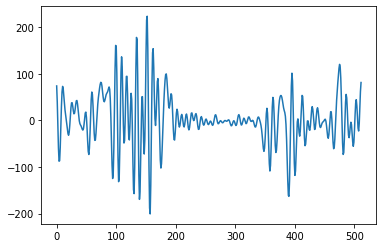

In [104]:
plt.plot(feature[10,2,:,3])
#plt.figure()
#plt.plot(feature.transpose((0,2,1,3))[10,0,:,4])

In [509]:
feature.shape

(2199, 6, 512, 8)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras import callbacks, Model, models
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

In [13]:
def train_model(model,feature,y,binary=True,file=None):
    if binary:
        ind = ((y==0)|(y==1)|(y==2)|(y==3)|(y==4)|(y==6))
        ind1 = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
        y_01 = y.copy()
        #ind1 = ((y_01==1)|(y_01==2)|(y_01==6))
        y_01[ind1] = 1
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:1,1:5}
    else:
        ind = ((y==1)|(y==2)|(y==6))
        #ind = ((y==2)|(y==6))
        y_01 = y[ind].copy()
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:5,1:1,2:1}#{0:2,1:1,2:10,3:2}
    x_full,x_test,y_full,y_test = train_test_split(np.array(feature)[ind,:],y_01,
                                                   test_size=0.2,
                                                   random_state=123,
                                                   shuffle=True)
    x_train,x_valid,y_train,y_valid = train_test_split(x_full,y_full,
                                                       test_size=0.25,
                                                       random_state=555,
                                                       shuffle=True)
    
    x_train = x_full
    
    early_stopping = callbacks.EarlyStopping(patience = 10,
                                             monitor = 'val_loss', 
                                             restore_best_weights=True)
    history = model.fit(x_train,y_full,validation_data=(x_test,y_test),
                        epochs=300,batch_size=32,class_weight=cw,
                        callbacks=[early_stopping],
                        shuffle=True)
    
    if binary:
        y_pred_t=model.predict(x_test)
        test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #test = accuracy_score(y_test,y_pred_t>0.5)
        
        #y_pred_v=model.predict(x_valid)
        #valid = accuracy_score(y_valid,np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))
        #train = accuracy_score(y_full,y_pred_ta>0.5)
        
        print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
        
        #print('train: \n',metrics.confusion_matrix(y_full,y_pred_ta>0.5))
        #print('test: \n',metrics.confusion_matrix(y_test,y_pred_t>0.5))

    else:
        y_pred_t=model.predict(x_test)
        test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #y_pred_v=model.predict(x_valid)
        #valid = metrics.accuracy_score(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))        
        print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
    print('test:%f'%test)
    #print('valid:%f'%valid)
    print('train:%f'%train)
    if file != None:
        model.save_model(file)
    return train,test

def test_model(model,feature,y,binary=True):
    if binary:
        ind = ((y==0)|(y==1)|(y==2)|(y==3)|(y==4)|(y==6))
        #ind1 = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
        y_01 = y[ind].copy()
        ind1 = ((y_01==1)|(y_01==2)|(y_01==6))
        y_01[ind1] = 1
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:1,1:5}
    else:
        ind = ((y==1)|(y==2)|(y==6))
        #ind = ((y==2)|(y==6))
        y_01 = y[ind].copy()
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:5,1:1,2:1}#{0:2,1:1,2:10,3:2}

    #print(y_01)
    #feature=sc.transform(feature[ind])
    #feature=pca.transform(feature)
    y_pred=model.predict(feature[ind])
    test = accuracy_score(np.argmax(y_01,axis=1),np.argmax(y_pred,axis=1))
    #test = metrics.accuracy_score(y_01,y_pred>0.5)
    
    print('acc:%f'%test)
    print(confusion_matrix(np.argmax(y_01,axis=1),np.argmax(y_pred,axis=1)))
    #print(metrics.confusion_matrix(y_01,y_pred>0.5))
    return test

def sparse_cost_sensitive_loss (y_true,y_pred):
    #cost_matrix = tf.constant([[0,1.5,1,1.5],
    #              [1,0,1,1],
    #              [5,10,0,5],
    #              [1.,1.,1,0]])
    cost_matrix = tf.constant([[0,2.,2],
                  [1,0,1],
                  [1.0,2.,0]])
    batch_cost_matrix = tf.nn.embedding_lookup(cost_matrix, tf.argmax(y_true,axis=1))
    eps = 1e-6
    probability = tf.clip_by_value(y_pred, eps, 1-eps)
    cost_values = tf.math.log(1-probability)*batch_cost_matrix
    loss = tf.reduce_mean(-tf.reduce_sum(cost_values, axis=1))
    return loss

In [105]:
rate=0.2
kernel_size=7
stride=2
acti='relu'

In [111]:
input_ = layers.Input(shape=feature[:,[0,1,4,5],:,:].shape[1:])
#bn = layers.BatchNormalization()(input_)
#max_pool = layers.MaxPooling2D((2,2))(input_)
#bn = layers.BatchNormalization()(input_)

cnn1 = layers.Conv1D(256,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(input_)
#cnn1 = layers.Conv1D(16,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
#                      padding='same')(cnn1)
#cnn1 = layers.BatchNormalization()(cnn1)
cnn1 = layers.Activation(acti)(cnn1)
cnn1 = layers.Dropout(rate)(cnn1)
#cnn1 = layers.MaxPooling1D(2)(cnn1)

cnn2 = layers.Conv1D(128,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn1)
#cnn2 = layers.Conv1D(32,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
#                      padding='same')(cnn2)
cnn2 = layers.BatchNormalization(momentum=0.8)(cnn2)
cnn2 = layers.Activation(acti)(cnn2)
cnn2 = layers.Dropout(rate)(cnn2)
#cnn2 = layers.MaxPooling1D(2)(cnn2)

cnn3 = layers.Conv1D(64,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn2)
#cnn3 = layers.Conv1D(64,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
#                      padding='same')(cnn3)
cnn3 = layers.BatchNormalization(momentum=0.8)(cnn3)
cnn3 = layers.Activation(acti)(cnn3)
cnn3 = layers.Dropout(rate)(cnn3)
#cnn3 = layers.MaxPooling1D(2)(cnn3)

cnn4 = layers.Conv1D(32,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn3)
#cnn4 = layers.Conv1D(32,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
#                      padding='same')(cnn4)
cnn4 = layers.BatchNormalization(momentum=0.8)(cnn4)
cnn4 = layers.Activation(acti)(cnn4)
cnn4 = layers.Dropout(rate)(cnn4)
#cnn4 = layers.MaxPooling1D(2)(cnn4)

cnn5 = layers.Conv1D(16,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn4)
#cnn5 = layers.Conv1D(16,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
#                      padding='same')(cnn4)
cnn5 = layers.BatchNormalization(momentum=0.8)(cnn5)
cnn5 = layers.Activation(acti)(cnn5)
cnn5 = layers.Dropout(rate)(cnn5)
#cnn4 = layers.MaxPooling1D(2)(cnn4)

cnn6 = layers.Conv1D(8,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn5)
#cnn5 = layers.Conv1D(16,kernel_size,strides=stride,
                      #kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
#                      padding='same')(cnn4)
cnn6 = layers.BatchNormalization(momentum=0.8)(cnn6)
cnn6 = layers.Activation(acti)(cnn6)
cnn6 = layers.Dropout(rate)(cnn6)
#cnn4 = layers.MaxPooling1D(2)(cnn4)

flatten = layers.Flatten()(cnn6)
dropout = layers.Dropout(rate)(flatten)
#layer1 = layers.Dense(256,activation = 'relu')(dropout)
#dropout1 = layers.Dropout(0.2)(layer1)
#layer2 = layers.Dense(128,activation = 'relu')(dropout1)
#dropout2 = layers.Dropout(0.2)(layer2)
output = layers.Dense(3,activation = 'softmax')(dropout)
model = Model(inputs=[input_],outputs=[output])

In [112]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#early_stopping = callbacks.EarlyStopping(patience = 10,monitor = 'val_accuracy', restore_best_weights=True)

In [113]:
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4, 512, 6)]       0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 4, 256, 256)       11008     
_________________________________________________________________
activation_60 (Activation)   (None, 4, 256, 256)       0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 4, 256, 256)       0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 4, 128, 128)       229504    
_________________________________________________________________
batch_normalization_50 (Batc (None, 4, 128, 128)       512       
_________________________________________________________________
activation_61 (Activation)   (None, 4, 128, 128)     

In [ ]:
start = time.time()
train_model(model,feature[:,[0,1,4,5],:,:],Y,False)
end = time.time()
print(end-start)

Epoch 1/300
40/40 [==============================] - 31s 777ms/step - loss: 0.9722 - accuracy: 0.4922 - val_loss: 0.8314 - val_accuracy: 0.6395
Epoch 2/300
40/40 [==============================] - 29s 726ms/step - loss: 0.8326 - accuracy: 0.6107 - val_loss: 0.7775 - val_accuracy: 0.6520
Epoch 3/300
40/40 [==============================] - 32s 792ms/step - loss: 0.7734 - accuracy: 0.6523 - val_loss: 0.6813 - val_accuracy: 0.6834
Epoch 4/300
40/40 [==============================] - 31s 764ms/step - loss: 0.7018 - accuracy: 0.6852 - val_loss: 0.6311 - val_accuracy: 0.7210
Epoch 5/300
40/40 [==============================] - 31s 785ms/step - loss: 0.6511 - accuracy: 0.7049 - val_loss: 0.6223 - val_accuracy: 0.7116
Epoch 6/300
40/40 [==============================] - 29s 722ms/step - loss: 0.6441 - accuracy: 0.7182 - val_loss: 0.6098 - val_accuracy: 0.7179
Epoch 7/300
40/40 [==============================] - 28s 700ms/step - loss: 0.5913 - accuracy: 0.7292 - val_loss: 0.5899 - val_accuracy:

In [110]:
test_model(model,feature2[:,[0,1,4,5],:,:],Y2,False)

acc:0.836186
[[ 64  11  13]
 [ 17 173   5]
 [  8  13 105]]


0.8361858190709046